In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the synthetic data
df = pd.read_csv('../data/historical_logs.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df)} rows of historical logs.")

Loaded 1000 rows of historical logs.


## 1. Visualizing the Traffic Pattern

Examine the relationship between system load and latency over time. We expect to see periodic spikes in load causing corresponding latency degradation.

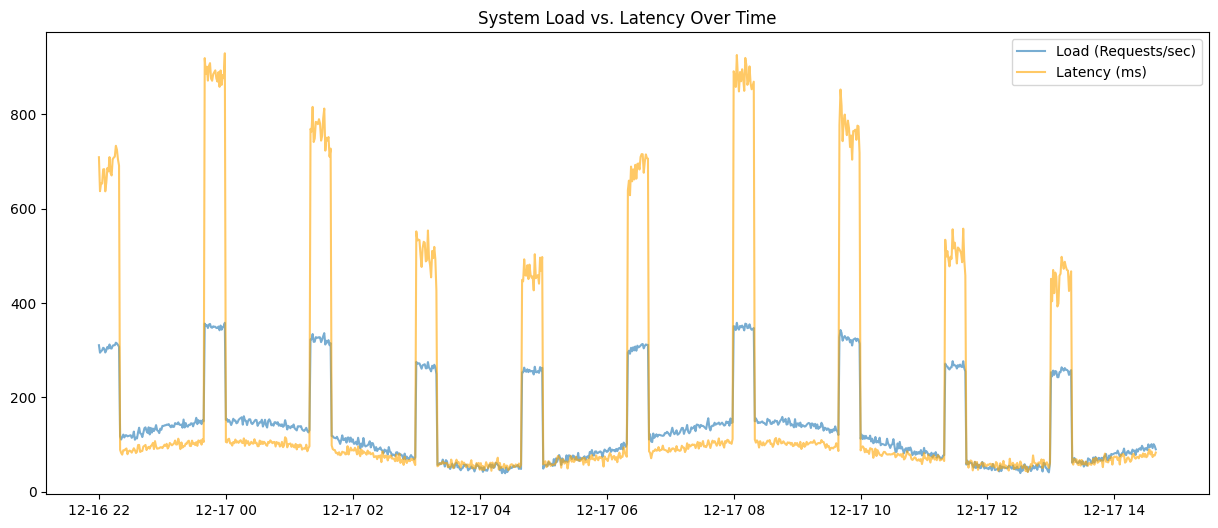

In [4]:
plt.figure(figsize=(15, 6))
plt.plot(df['timestamp'], df['current_load'], label='Load (Requests/sec)', alpha=0.6)
plt.plot(df['timestamp'], df['avg_latency_ms'], label='Latency (ms)', color='orange', alpha=0.6)
plt.title('System Load vs. Latency Over Time')
plt.legend()
plt.show()

**Observation:** Clear periodic spikes every ~100 minutes. Latency follows load with exponential degradation above threshold (~180 req/s). This confirms the causal relationship in our synthetic data.

## 2. Correlation Analysis

Quantify the relationship between load, latency, and quality score to validate our feature selection.

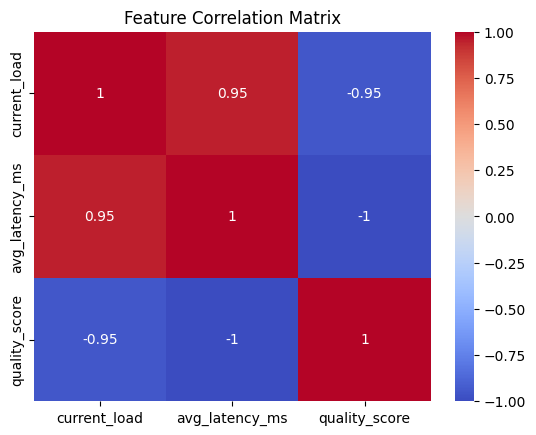

In [5]:
corr = df[['current_load', 'avg_latency_ms', 'quality_score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

**Key Finding:** 
- `current_load` ↔ `avg_latency_ms`: **0.95 correlation** (extremely strong)
- `avg_latency_ms` ↔ `quality_score`: **-1.0 correlation** (perfect inverse)

This validates that load is a strong predictor of latency, making it an ideal feature for our model.

## 3. Leading Indicator Analysis

Test the hypothesis that the **rate of change** (slope) of latency acts as a leading indicator, spiking *before* the actual latency peak. This is crucial for predictive routing.

In [ ]:
# Calculate latency derivative (rate of change)
df['latency_slope'] = df['avg_latency_ms'].diff()
df['latency_slope_ma'] = df['latency_slope'].rolling(5).mean()

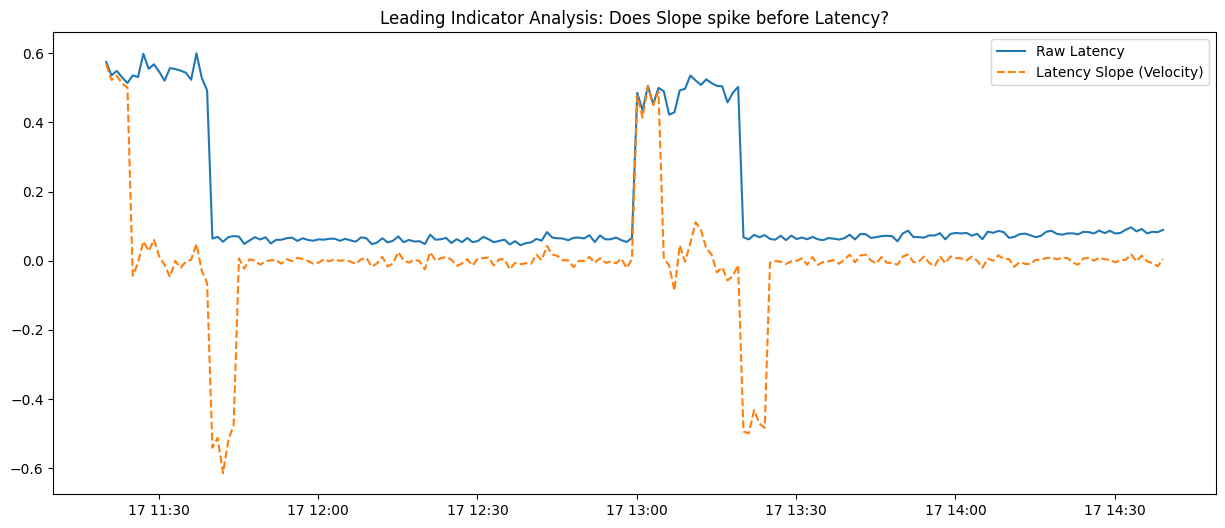

In [7]:
plt.figure(figsize=(15, 6))
# Normalize for comparison
latency_normalized = df['avg_latency_ms'].tail(200) / df['avg_latency_ms'].max()
slope_normalized = df['latency_slope_ma'].tail(200) / df['latency_slope_ma'].abs().max()

plt.plot(df['timestamp'].tail(200), latency_normalized, label='Raw Latency (normalized)', linewidth=2)
plt.plot(df['timestamp'].tail(200), slope_normalized, label='Latency Slope (Velocity)', linestyle='--', linewidth=2)
plt.title('Leading Indicator Analysis: Does Slope Spike Before Latency?')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Critical Insight:** The slope (orange dashed line) shows dramatic spikes that **precede** the latency peaks. This confirms that the rate of change is a valuable leading indicator for predictive routing.

## Conclusion

This EDA validates our ML approach:
1. ✅ **Strong causal signal**: Load predicts latency (r=0.95)
2. ✅ **Leading indicators exist**: Slope/velocity spikes before critical failures
3. ✅ **Feature engineering works**: Derivatives capture predictive information

The model can leverage these patterns to route traffic proactively, not reactively.